<a href="https://colab.research.google.com/github/jcmachicaocuf/ecosys_demos/blob/main/apples_data_dragin_variety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Technical Note
# Inferring Latent Information from Observable Features via Synthetic Apple Data Objective
José Carlos Machicao, Lecturer


This experiment investigates whether observable features—specifically diameter and weight of apples—implicitly contain information about unobserved latent variables, such as apple variety. The core hypothesis is that patterns and distributions in the data encode more information than the raw columns themselves.

Methodology
Synthetic Dataset Creation: We generate data for 200 apples, each assigned to one of two hidden varieties (A or B).

Feature Generation:

Diameter is sampled from a normal distribution.

Weight is computed as a non-linear function of diameter, with parameters subtly altered by the hidden variety:

Weight = 𝑎⋅(Diameter)2 + 𝜖
Weight = a⋅(Diameter)2 + ϵ

Latent Structure: The hidden variable (variety) influences the weight indirectly, introducing structure into the joint distribution of diameter and weight.

Analysis Techniques
Visualization:

Scatter plots and hexbin plots are used to highlight density-based patterns.

PCA (Principal Component Analysis) is applied to reduce dimensionality and explore variance structure.

Unsupervised Learning:

K-Means clustering is applied using only diameter and weight to attempt recovery of the hidden variety.

Cluster assignments are compared against the true (but hidden) variety labels using a confusion matrix.

Conclusion
Preliminary results show that, even without explicit variety labels, statistical patterns in observable features enable recovery of the underlying class structure. This demonstrates that data columns “drag in” latent information, which can be extracted using thoughtful analysis and modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [2]:
# Seed for reproducibility
np.random.seed(42)

# Simulate 80 apples with hidden variety
n = 80
variety = np.random.choice(['A', 'B'], size=n)  # Hidden variable: apple variety

# Generate diameters
diameter = np.random.normal(7.0, 0.5, size=n)

In [3]:
# Generate weight as a function of diameter and hidden variety
# Variety A: lighter apples, Variety B: heavier for same diameter
weight = []
for d, v in zip(diameter, variety):
    if v == 'A':
        w = 0.4 * d**2 + np.random.normal(0, 5)
    else:
        w = 0.6 * d**2 + np.random.normal(0, 5)
    weight.append(w)

# Create DataFrame
df = pd.DataFrame({
    'Diameter': diameter,
    'Weight': weight,
    'Variety': variety  # Hidden in real-world scenario
})

In [4]:
# Fit linear regression
model = LinearRegression()
model.fit(df[['Diameter']], df['Weight'])
df['Predicted_Weight'] = model.predict(df[['Diameter']])

# PCA to check if there's more structure
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[['Diameter', 'Weight']])
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

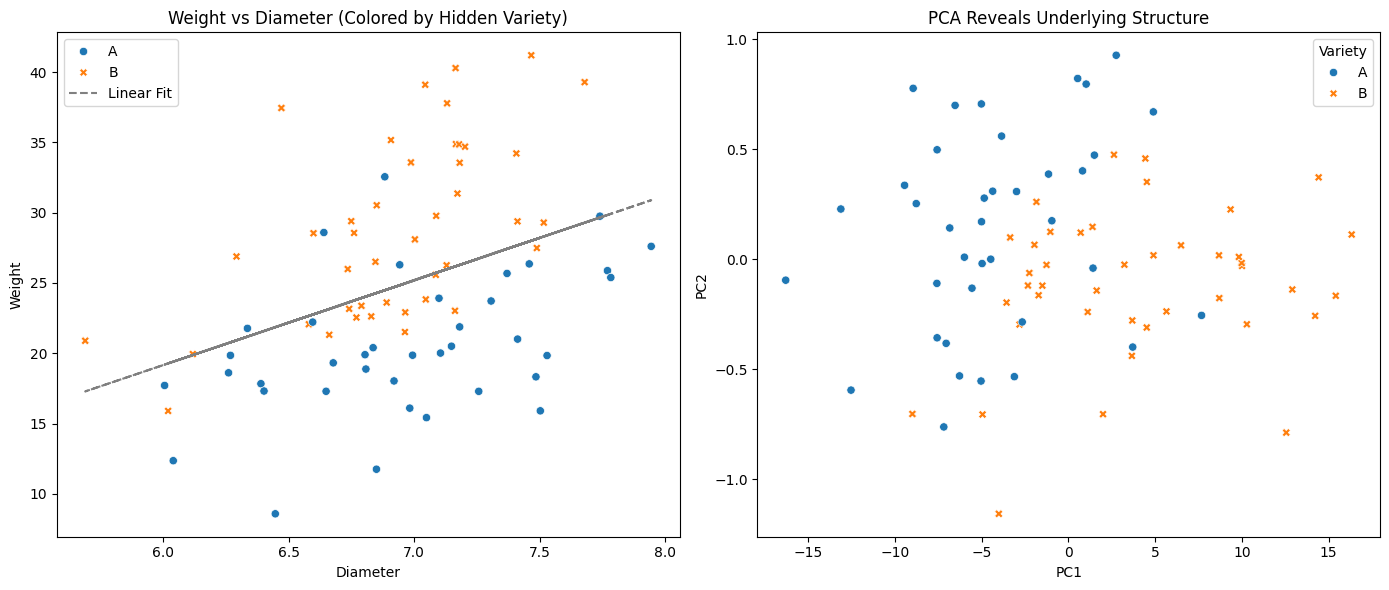

In [5]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Weight vs Diameter with variety color
sns.scatterplot(ax=axes[0], data=df, x='Diameter', y='Weight', hue='Variety', style='Variety')
axes[0].plot(df['Diameter'], df['Predicted_Weight'], color='gray', linestyle='--', label='Linear Fit')
axes[0].set_title('Weight vs Diameter (Colored by Hidden Variety)')
axes[0].legend()

# Plot 2: PCA of the data
sns.scatterplot(ax=axes[1], data=df, x='PC1', y='PC2', hue='Variety', style='Variety')
axes[1].set_title('PCA Reveals Underlying Structure')

plt.tight_layout()
plt.show()

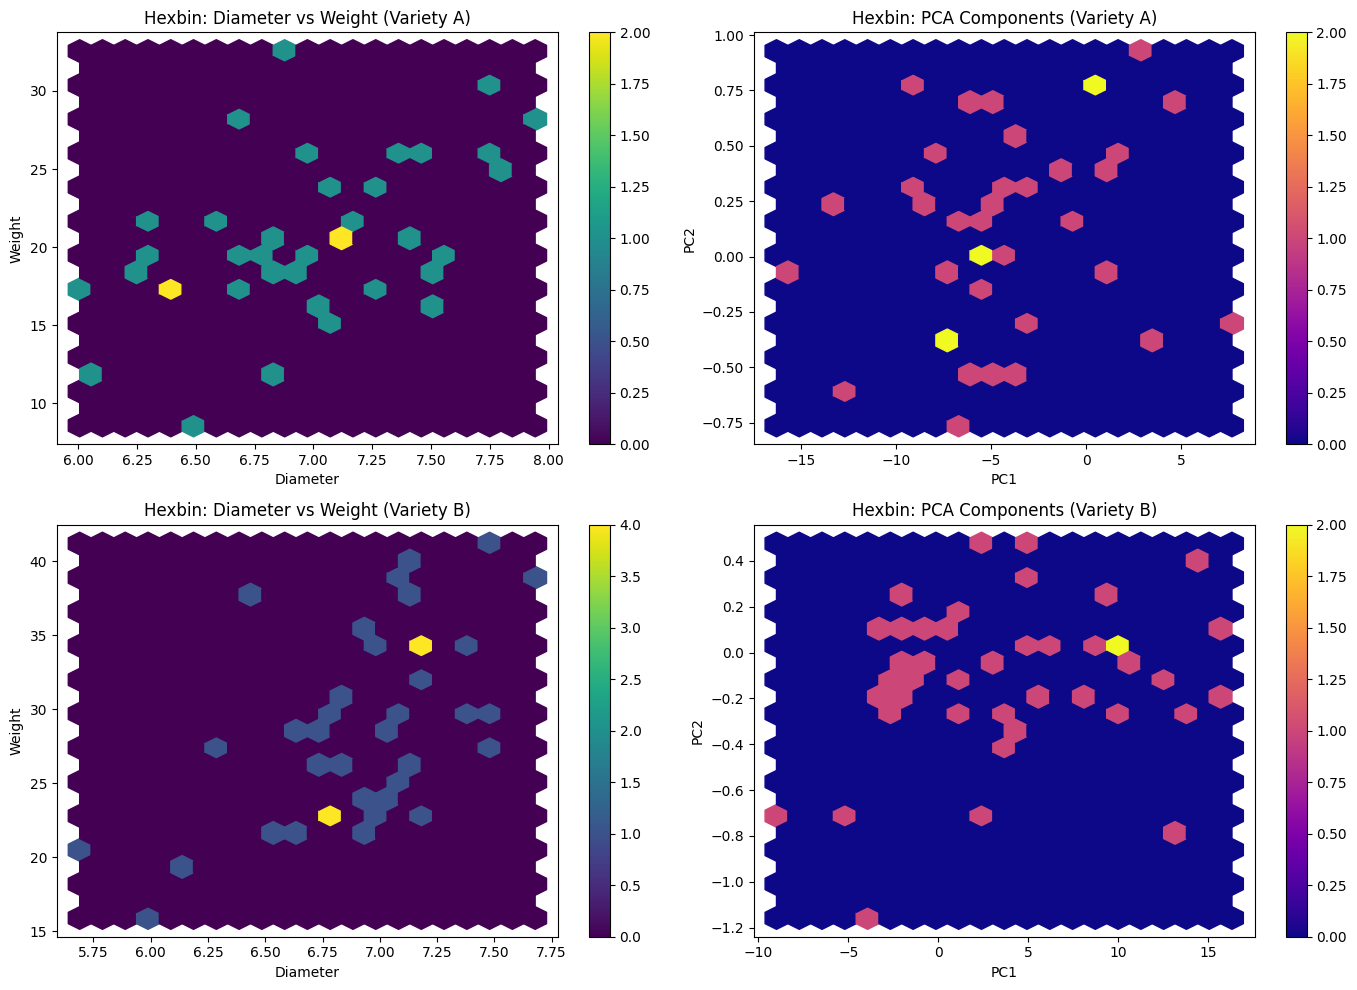

In [6]:
# Create hexbin plots separated by variety, arranged in two rows
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

varieties = ['A', 'B']
cmaps = ['viridis', 'plasma']

for i, variety in enumerate(varieties):
    subset = df[df['Variety'] == variety]

    # Hexbin: Diameter vs Weight
    hb1 = axes[i][0].hexbin(subset['Diameter'], subset['Weight'], gridsize=20, cmap=cmaps[0])
    axes[i][0].set_xlabel('Diameter')
    axes[i][0].set_ylabel('Weight')
    axes[i][0].set_title(f'Hexbin: Diameter vs Weight (Variety {variety})')
    fig.colorbar(hb1, ax=axes[i][0])

    # Hexbin: PCA Components
    hb2 = axes[i][1].hexbin(subset['PC1'], subset['PC2'], gridsize=20, cmap=cmaps[1])
    axes[i][1].set_xlabel('PC1')
    axes[i][1].set_ylabel('PC2')
    axes[i][1].set_title(f'Hexbin: PCA Components (Variety {variety})')
    fig.colorbar(hb2, ax=axes[i][1])

plt.tight_layout()
plt.show()

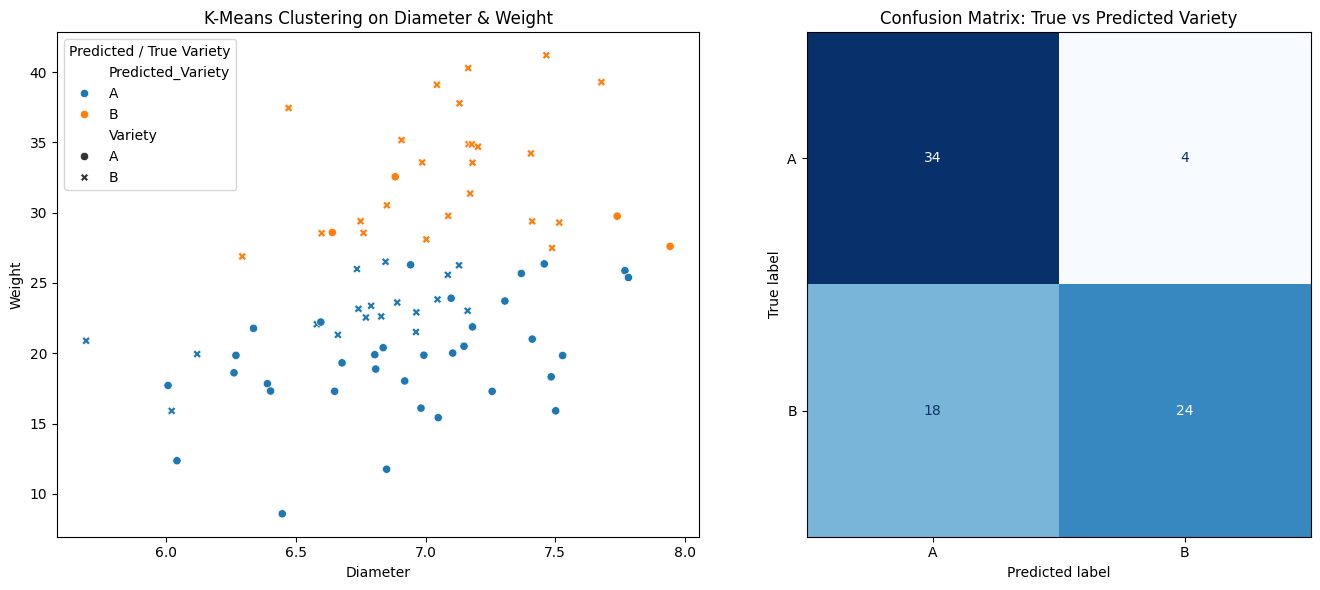

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Perform k-means clustering on Diameter and Weight
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Diameter', 'Weight']])

# Map cluster labels to match actual varieties as best as possible
# We'll assume the cluster with majority of 'A' becomes 'A', and similarly for 'B'
cluster_to_variety = {}
for cluster_label in df['Cluster'].unique():
    majority_variety = df[df['Cluster'] == cluster_label]['Variety'].mode()[0]
    cluster_to_variety[cluster_label] = majority_variety

# Assign predicted variety based on cluster
df['Predicted_Variety'] = df['Cluster'].map(cluster_to_variety)

# Confusion matrix
cm = confusion_matrix(df['Variety'], df['Predicted_Variety'], labels=['A', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B'])

# Plot clustering result and confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cluster visualization
sns.scatterplot(ax=axes[0], data=df, x='Diameter', y='Weight', hue='Predicted_Variety', style='Variety')
axes[0].set_title('K-Means Clustering on Diameter & Weight')
axes[0].legend(title='Predicted / True Variety')

# Confusion matrix
disp.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Confusion Matrix: True vs Predicted Variety')

plt.tight_layout()
plt.show()
